In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from typing import List, Tuple, Dict, Any, Union, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.dates as mdates
import scipy.stats as stats

tqdm.pandas()

In [2]:
KAGGLE = True

In [3]:
if KAGGLE: 
    FEATURES_PATH = '/kaggle/input/regionalrhythms/audio_features_processed.csv'
    CHARTS_PATH = "/kaggle/input/regionalrhythms/charts_processed.csv"
    OUTPUT_PATH = '/kaggle/working'
    CHARTS_V2_PATH = '/kaggle/input/regionalrhythms/charts_processed_v2.csv'
else:
    FEATURES_PATH = "../../data/audio_features_processed.csv"
    CHARTS_PATH = "../../data/charts_processed.csv"
    OUTPUT_PATH = "../../output"
    CHARTS_V2_PATH = "../../data/charts_processed_v2.csv"

In [4]:
def blocks(files, size=65536):
    while True:
        b = files.read(size)
        if not b: break
        yield b

num_lines = 0
with open(CHARTS_V2_PATH, "r",encoding="utf-8",errors='ignore') as f:
    num_lines = sum(bl.count("\n") for bl in blocks(f))
    
# Load the datasets into dataframes
with tqdm(total=int(num_lines)) as bar:
    charts_df = pd.read_csv(CHARTS_V2_PATH, parse_dates=['date'], date_format='%Y-%m-%d', skiprows=lambda x: bar.update(1) and False)
charts_df.head()

100%|██████████| 20321859/20321859 [00:42<00:00, 473452.75it/s]


title  rank       date  \
0      Chantaje (feat. Maluma)     1 2017-01-01   
1  Vente Pa' Ca (feat. Maluma)     2 2017-01-01   
2   Reggaetón Lento (Bailemos)     3 2017-01-01   
3                       Safari     4 2017-01-01   
4                  Shaky Shaky     5 2017-01-01   

                                  artist     region   streams  \
0                                Shakira  Argentina  253019.0   
1                           Ricky Martin  Argentina  223988.0   
2                                   CNCO  Argentina  210943.0   
3  J Balvin, Pharrell Williams, BIA, Sky  Argentina  173865.0   
4                           Daddy Yankee  Argentina  153956.0   

                 track_id  streams_percentage  
0  6mICuAdrwEjh6Y6lroV2Kg            0.032073  
1  7DM4BPaS7uofFul3ywMe46            0.028393  
2  3AEZUABDXNtecAOSC1qTfo            0.026739  
3  6rQSrBHf7HlZjtcMZ4S4bO            0.022039  
4  58IL315gMSTD37DOZPJ2hf            0.019516

In [5]:
# Load the audio features dataset
audio_df = pd.read_csv(FEATURES_PATH)

# Change the column-name of 'id' to 'track_id' to match the charts_df
audio_df.rename(columns={'id': 'track_id'}, inplace=True)
audio_df.head()

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0       0.18700         0.852       195840   0.773          0.000030    8   
1       0.00431         0.663       259196   0.920          0.000017   11   
2       0.40000         0.761       222560   0.838          0.000000    4   
3       0.55100         0.508       205600   0.687          0.000003    0   
4       0.07600         0.899       234320   0.626          0.000000    6   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1590    -2.921     0       0.0776  102.034               4    0.907   
1    0.1010    -4.070     0       0.2260   99.935               4    0.533   
2    0.1760    -3.073     0       0.0502   93.974               4    0.710   
3    0.1260    -4.361     1       0.3260  180.044               4    0.555   
4    0.0631    -4.228     0       0.2920   88.007               4    0.873   

                 track_id  
0  6mICuAdrwEjh6Y6lroV2Kg  
1  7DM4BPaS7uofFul3ywMe46  
2  3AEZUABDXNtecAOSC1qTfo  
3  6rQSrBHf7HlZjtcMZ4S4bO  
4  58IL315gMSTD37DOZPJ2hf

In [6]:
# Drop all the tracks that are not in the features dataset
# first check how many tracks are in the charts_df but not in the audio_df
print("Number of tracks in charts_df but not in audio_df: ", len(charts_df[~charts_df["track_id"].isin(audio_df["track_id"])]))
charts_df = charts_df[charts_df["track_id"].isin(audio_df["track_id"])]

Number of tracks in charts_df but not in audio_df:  0


In [7]:
# Merge the data
data = pd.merge(charts_df, audio_df, on="track_id")

In [8]:
data.head()

title  rank       date   artist     region   streams  \
0  Chantaje (feat. Maluma)     1 2017-01-01  Shakira  Argentina  253019.0   
1  Chantaje (feat. Maluma)   138 2017-01-01  Shakira  Australia   13216.0   
2  Chantaje (feat. Maluma)    62 2017-01-01  Shakira    Austria    3245.0   
3  Chantaje (feat. Maluma)    61 2017-01-01  Shakira    Belgium    4635.0   
4  Chantaje (feat. Maluma)     3 2017-01-01  Shakira    Bolivia    5506.0   

                 track_id  streams_percentage  acousticness  danceability  \
0  6mICuAdrwEjh6Y6lroV2Kg            0.032073         0.187         0.852   
1  6mICuAdrwEjh6Y6lroV2Kg            0.002458         0.187         0.852   
2  6mICuAdrwEjh6Y6lroV2Kg            0.005242         0.187         0.852   
3  6mICuAdrwEjh6Y6lroV2Kg            0.004828         0.187         0.852   
4  6mICuAdrwEjh6Y6lroV2Kg            0.038414         0.187         0.852   

   ...  energy  instrumentalness  key  liveness  loudness  mode  speechiness  \
0  ...   0.773           0.00003    8     0.159    -2.921     0       0.0776   
1  ...   0.773           0.00003    8     0.159    -2.921     0       0.0776   
2  ...   0.773           0.00003    8     0.159    -2.921     0       0.0776   
3  ...   0.773           0.00003    8     0.159    -2.921     0       0.0776   
4  ...   0.773           0.00003    8     0.159    -2.921     0       0.0776   

     tempo  time_signature  valence  
0  102.034               4    0.907  
1  102.034               4    0.907  
2  102.034               4    0.907  
3  102.034               4    0.907  
4  102.034               4    0.907  

[5 rows x 21 columns]

In [9]:
full_data = 365 * 5 * 200
full_data # the amount of data that I expect for 5 years of daily chart results with 200 ranks

365000

In [10]:
# integrity ratio by region

region_data_volume = np.round(data['region'].value_counts() * 100 / full_data, 1)
region_data_volume

region
Brazil           99.9
Argentina        99.8
United States    99.8
Austria          99.7
Australia        99.2
                 ... 
Russia           27.6
Ukraine          27.6
Bulgaria         26.0
South Korea      16.3
Luxembourg        2.5
Name: count, Length: 69, dtype: float64

In [11]:
complete_regions = region_data_volume[region_data_volume >= 95].index.to_list()
complete_regions.remove('Global')
complete_regions

['Brazil',
 'Argentina',
 'United States',
 'Austria',
 'Australia',
 'Canada',
 'United Kingdom',
 'Switzerland',
 'Philippines',
 'Malaysia',
 'France',
 'Ireland',
 'Belgium',
 'Indonesia',
 'Singapore',
 'Hong Kong',
 'Sweden',
 'Denmark',
 'New Zealand',
 'Colombia',
 'Costa Rica',
 'Italy',
 'Ecuador',
 'Spain',
 'Mexico',
 'Finland',
 'Turkey',
 'Taiwan',
 'Norway',
 'Chile',
 'Peru',
 'Poland',
 'Netherlands',
 'Portugal',
 'Germany',
 'Czech Republic',
 'Japan',
 'Guatemala',
 'Uruguay']

In [12]:
def get_charts_by_date(df: pd.DataFrame, date: Union[str, Tuple[str, str]]) -> pd.DataFrame:
    """
    Get the elements of the dataframe that match the date.
    If date is a tuple, return the elements between the two dates.

    Parameters:
        df (pd.DataFrame): The dataframe to filter
        date (str or tuple): The date or the tuple of dates to filter the dataframe

    Returns:
        pd.DataFrame: The filtered dataframe
    """
    

    if isinstance(date, tuple):
        return df[(df['date'] >= pd.to_datetime(date[0])) & (df['date'] <= pd.to_datetime(date[1]))]
    else:
        return df[df['date'] == pd.to_datetime(date)]

def get_charts_by_region(df : pd.DataFrame, region : Union[str, List[str]]) -> pd.DataFrame:
    """
    Return the charts by region.
    If region is a list, return the charts for the regions in the list.

    Parameters:
        df (pd.DataFrame): The dataframe to filter
        region (str or list): The region or the list of regions to filter the dataframe

    Returns:
        pd.DataFrame: The filtered dataframe
    """
    if isinstance(region, list):
        return df[df['region'].isin(region)]
    return df[df['region'] == region]

def get_regional_weekly_charts_ranking(df : pd.DataFrame, date : Union[str, Tuple[str,str]], operation : str = 'sum', normalize_streams : bool = True) -> pd.DataFrame:
    """
    Transform daily data into weekly data. Rearange the rankings by getting the mean of streams and assigning a
    new ranking based on the mean. 

    Parameters:
        df (pd.DataFrame): The dataframe to filter. Should be the charts dataframe
        date (str or tuple): The date or the tuple of dates to filter the dataframe
        operation (str): The operation to perform on the streams. Either 'mean' or 'sum'

    Returns:
        pd.DataFrame: The filtered dataframe
    """
    # This should be a view and should not change the original df
    df = df.copy()
    df = get_charts_by_date(df, date)

    temp_df = df[['track_id', 'streams']].copy()


    if operation == 'mean':
        df_group = temp_df.groupby(['track_id']).mean().reset_index()
    elif operation == 'sum':
        df_group = temp_df.groupby(['track_id']).sum().reset_index()
    else:
        raise ValueError("Operation should be either 'mean' or 'sum'")
    
    # Sort the tracks by streams to get the rankings
    df_group = df_group.sort_values(by=['streams'], ascending=False).reset_index()

    # Assign the new rankings
    df_group['rank'] = df_group.index + 1

    # Merge the two dataframes so that df_group also include title, artist, region
    df_group = df_group.merge(df[['track_id', 'title', 'artist', 'region']], on='track_id', how='left')

    # Remove duplicates will look same after we merge the two dataframes
    df_group = df_group.drop_duplicates(subset=['track_id'])

    df_group["start_date"] = date[0] if isinstance(date,tuple) else date
    df_group["end_date"] = date[1] if isinstance(date,tuple) else date

    # Normalize the streams between 0 and 1
    if normalize_streams:
        df_group['streams'] = (df_group['streams'] - df_group['streams'].min()) / (df_group['streams'].max() - df_group['streams'].min())

    return df_group

In [13]:
# An example of getting monthly charts for Turkey
turkey_df = get_charts_by_region(data, 'Turkey')
turkey_weekly = get_regional_weekly_charts_ranking(turkey_df, ("1-1-2018", "1-30-2018"), normalize_streams=False)

In [14]:
turkey_weekly.head()

index                track_id    streams  rank              title  \
0       80  2BJkinM7TmdcsDGNvmZds8  2475718.0     1          Yanıyoruz   
30     184  4sa0pXDdQkBZ1r5NZWQJyV  2033558.0     2       Heyecanı Yok   
60     209  5dLtu0lS5pP9ivMerk3uMA  1686875.0     3  Gömün Beni Çukura   
90     282  7wGoVu4Dady5GV0Sv4UIsx  1589483.0     4           rockstar   
120    203  5Y3ZTBwRNrgj3AlXYASvDe  1489374.0     5         İmkansızım   

                     artist  region start_date   end_date  
0                Burak King  Turkey   1-1-2018  1-30-2018  
30                 Gazapizm  Turkey   1-1-2018  1-30-2018  
60                    Eypio  Turkey   1-1-2018  1-30-2018  
90   Post Malone, 21 Savage  Turkey   1-1-2018  1-30-2018  
120                   Ezhel  Turkey   1-1-2018  1-30-2018

In [15]:
len(turkey_weekly["track_id"])

283

In [16]:
def get_distance_intersection(df1 : pd.DataFrame, df2 : pd.DataFrame) -> float:
    # find the songs that are in both dataframes
    return -len(set(df1["track_id"]).intersection(set(df2["track_id"]))) 

# jackard similarity
def get_similarity_jackard(df1 : pd.DataFrame, df2 : pd.DataFrame) -> float:
    # find the songs that are in both dataframes
    intersection = len(set(df1["track_id"]).intersection(set(df2["track_id"])))
    # find the songs that are in either of the dataframes
    union = len(set(df1["track_id"]).union(set(df2["track_id"])))
    return intersection / union

def get_distance_ranking(df1 : pd.DataFrame, df2 : pd.DataFrame) -> float:
    # find the songs that are in both dataframes
    intersection = set(df1["track_id"]).intersection(set(df2["track_id"]))
    # find the songs that are in either of the dataframes
    union = set(df1["track_id"]).union(set(df2["track_id"]))
    # calculate the difference between the rankings
    difference = 0
    for track_id in intersection:
        difference += abs(df1[df1["track_id"] == track_id]["rank"].iloc[0] - df2[df2["track_id"] == track_id]["rank"].iloc[0])
    return difference / len(union)

#The KT distance is the number of pairs of permutation elements that have a different ordering in the two permutations.
def my_kendall_tau_dist(p1, p2):
  # p1, p2 are 0-based lists or np.arrays permutations
  n = len(p1)
  index_of = [None] * n  # lookup into p2
  for i in range(n):
    v = p2[i]; index_of[v] = i

  d = 0  # raw distance = number pair mis-orderings
  for i in range(n):  # scan thru p1
    for j in range(i+1, n):
      if index_of[p1[i]] > index_of[p1[j]]:
        d += 1
  normer = n * (n - 1) / 2.0  # total num pairs 
  nd = d / normer  # normalized distance
  return (d, nd) 

def get_similarity_kendaltau(df1 : pd.DataFrame, df2 : pd.DataFrame) -> float:
    # find the songs that are in both dataframes
    intersection = set(df1["track_id"]).intersection(set(df2["track_id"]))
    # align so that the each dataframe is from the most popular to the least popular
    df1 = df1[df1["track_id"].isin(intersection)].sort_values(by=['rank'], ascending=True).reset_index()
    df2 = df2[df2["track_id"].isin(intersection)].sort_values(by=['rank'], ascending=True).reset_index()

    # assign translate the ids from hash to int but keep the information about the original id
    df1["track_id"] = df1["track_id"].astype('category').cat.codes
    df2["track_id"] = df2["track_id"].astype('category').cat.codes

    # calculate the kendal tau distance
    kendaltau = my_kendall_tau_dist(df1["track_id"], df2["track_id"])[1]
    #print(kendaltau)
    return 1 - kendaltau 


# a function that returns a function that calculates the similarity between two dataframes
def get_similarity_weighted(jackard_weight : float = 0.5, kendaltau_weight : float = 0.5):
    def similarity(df1 : pd.DataFrame, df2 : pd.DataFrame) -> float:
        return get_similarity_jackard(df1, df2) * get_similarity_kendaltau(df1, df2)
    return similarity

#assert get_similarity_jackard(turkey_weekly, turkey_weekly) == 1
#assert get_distance_ranking(turkey_weekly, turkey_weekly) == 0
#assert get_distance_intersection(turkey_weekly, turkey_weekly) == -len(turkey_weekly)

def test_custom_kendal_tau():
    # test with only permutations
    assert my_kendall_tau_dist([0,1,2,3], [0,1,2,3]) == (0, 0)
    assert my_kendall_tau_dist([0,1,2,3], [3,2,1,0]) == (6, 1)
    assert my_kendall_tau_dist([0,1,2,3], [1,2,3,0]) == (3, 1/2)

def test_get_similariy_kendaltau():
    # test with custom dataframes with rank and track_id
    df1 = pd.DataFrame({"track_id": [0,1,2,3], "rank": [1,2,3,4]})
    df2 = pd.DataFrame({"track_id": [0,1,2,3], "rank": [1,2,3,4]})
    assert get_similarity_kendaltau(df1, df2) == 1

    df1 = pd.DataFrame({"track_id": [0,1,2,3], "rank": [1,2,3,4]})
    df2 = pd.DataFrame({"track_id": [0,1,2,3], "rank": [4,3,2,1]})
    assert get_similarity_kendaltau(df1, df2) == 0

    df1 = pd.DataFrame({"track_id": [0,1,2,3], "rank": [1,2,3,4]})
    df2 = pd.DataFrame({"track_id": [0,1,2,3], "rank": [2,3,4,1]})
    assert get_similarity_kendaltau(df1, df2) == 1/2

    df1 = pd.DataFrame({"track_id": [0,1,2,3], "rank": [1,2,3,4]})
    df2 = pd.DataFrame({"track_id": [3,2,1,0], "rank": [4,3,2,1]})
    assert get_similarity_kendaltau(df1, df2) == 1

    # test when the ids are strings
    df1 = pd.DataFrame({"track_id": ["0","1","2","3"], "rank": [1,2,3,4]})
    df2 = pd.DataFrame({"track_id": ["0","1","2","3"], "rank": [1,2,3,4]})
    assert get_similarity_kendaltau(df1, df2) == 1

    df1 = pd.DataFrame({"track_id": ["0","1","2","3"], "rank": [1,2,3,4]})
    df2 = pd.DataFrame({"track_id": ["0","1","2","3"], "rank": [4,3,2,1]})
    assert get_similarity_kendaltau(df1, df2) == 0

    # ids are words
    df1 = pd.DataFrame({"track_id": ["a","b","c","d"], "rank": [1,2,3,4]})
    df2 = pd.DataFrame({"track_id": ["a","b","c","d"], "rank": [1,2,3,4]})
    assert get_similarity_kendaltau(df1, df2) == 1

    df1 = pd.DataFrame({"track_id": ["a","b","c","d"], "rank": [1,2,3,4]})
    df2 = pd.DataFrame({"track_id": ["a","b","c","d"], "rank": [4,3,2,1]})
    assert get_similarity_kendaltau(df1, df2) == 0


test_custom_kendal_tau()
test_get_similariy_kendaltau()

In [17]:
def get_region_matrix_dict(df : pd.DataFrame, regions : List[str],  start_date : str, end_date : str, mode : str, selected_region: str = None, similarity_function : Callable[[pd.DataFrame, pd.DataFrame], float] = get_similarity_jackard) -> Dict[Tuple[str,str], np.ndarray]:
    # create the region array
    region_array = np.array(regions)
    # get the dates according to the mode
    if mode == "weekly":
        dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')
    elif mode == "monthly":
        dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    elif mode == "yearly":
        dates = pd.date_range(start=start_date, end=end_date, freq='AS')
    else:
        raise ValueError("Mode should be either 'weekly', 'monthly' or 'yearly'")

    # create the region matrix
    region_matrix_dict = {}
    # create a tuple of the date ranges
    date_ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]
    # use tqdm to show the progress bar
    for i, date_range in tqdm(date_ranges):
        # todo: optimize continue section
        # get the regional weekly charts for the date range
        regional_charts = [get_regional_weekly_charts_ranking(get_charts_by_region(df, region), date_range) for region in regions]
        # calculate the difference between the regions
        for j, region1 in enumerate(regions):
            for k, region2 in enumerate(regions):
                # skip if the regions are the same and also skip if the difference is already calculated
                if region1 == region2 or (region2, region1) in region_matrix_dict or (selected_region is not None and region1 != selected_region):
                    continue
                # append the difference to the dictionary value which is an array
                if (region1, region2) in region_matrix_dict:
                    region_matrix_dict[(region1, region2)].append(similarity_function(regional_charts[j], regional_charts[k]))
                else:
                    region_matrix_dict[(region1, region2)] = [similarity_function(regional_charts[j], regional_charts[k])]

    # also return an information dictionary that contains the period, aggreagate mode (daily, weekly, monthly, yearly), the difference function and the selected region
    info_dict = {"period": (start_date, end_date), "mode": mode, "similarity_function": similarity_function.__name__, "selected_region": selected_region}
            
    return region_matrix_dict, region_array, date_ranges, info_dict

# plot the line plot for the region dictionary
def plot_region_matrix_dict(region_matrix_dict : Dict[Tuple[str,str], np.ndarray], dates : List[str], info_dict : Dict[str, Any] ):
    # create the figure
    fig = plt.figure(figsize=(20,10))
    # create the axis
    ax = fig.add_subplot(111)
    # transform the dates into the first date of each tuple
    dates_start = [date[0] for date in dates]
    # add the last date end to the dates
    #dates_start.append(dates[-1][1])
    # plot the lines
    for key in region_matrix_dict:
        ax.plot(dates_start, region_matrix_dict[key], label=key)
    # set the x axis
    ax.set_xticks(dates_start)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    # ax.xaxis.set_major_formatter(DateFormatter('%b'))
    # ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # set the x axis labels
    # ax.set_xticklabels(dates_start, rotation=45)
    # find the min and max of the values
    min_value = np.array(list(region_matrix_dict.values())).min()
    max_value = np.array(list(region_matrix_dict.values())).max()
    # set the y axis min and max of the values
    ax.set_yticks(np.arange(min_value, max_value, (max_value-min_value)/10).round(2))
    # set the y axis labels
    ax.set_yticklabels(np.arange(min_value, max_value, (max_value-min_value)/10).round(2))
    # set a descriptive title that includes the period, aggreagate mode (daily, weekly, monthly, yearly), the difference function and the selected region
    ax.set_title(f"Period: {info_dict['period']}, Mode: {info_dict['mode']}, Similarity Function: {info_dict['similarity_function']}, Selected Region: {info_dict['selected_region']}")
     
    # set the legend
    ax.legend()
    # show the plot
    plt.show()

In [18]:
# method to get the most influential region. Which is measured by the region which has the most similarity with the other regions given the similarity dictionary
# example: the keys of the region dictionary are (region1, region2) and the values are the differences between the regions
# dict_keys([('Turkey', 'Japan'), ('Turkey', 'United States'), ('Turkey', 'United Kingdom'), ('Japan', 'United States'), ('Japan', 'United Kingdom'), ('United States', 'United Kingdom')])
def get_region_influence_ranking(region_matrix_dict : Dict[Tuple[str,str], np.ndarray], regions : List[str]) -> pd.DataFrame:
    # create the dataframe
    df = pd.DataFrame(columns=['region', 'influence'])
    # create the region array
    region_array = np.array(regions)
    # create the region influence array
    region_influence_array = np.zeros(len(regions))
    # iterate over the region matrix dictionary
    # also consider the reverse of the key
    for key in tqdm(region_matrix_dict):
        # get the index of the region in the region array
        index = np.where(region_array == key[0])[0][0]
        # add the difference to the region influence array
        region_influence_array[index] += np.array(region_matrix_dict[key]).mean()
        # get the index of the region in the region array
        index = np.where(region_array == key[1])[0][0]
        # add the difference to the region influence array
        region_influence_array[index] += np.array(region_matrix_dict[key]).mean()
        #print("The mean of similarity between {} and {} is {}".format(key[0], key[1], np.array(region_matrix_dict[key]).mean()))
    # add the region influence array to the dataframe
    df['region'] = region_array
    df['influence'] = region_influence_array
    # sort the dataframe by the influence
    df = df.sort_values(by=['influence'], ascending=False).reset_index(drop=True)
    return df

In [19]:
mixedDF = get_charts_by_region(charts_df, complete_regions)
print("Started calculating")
region_dict, region_array, dates, info_dict = get_region_matrix_dict(mixedDF, complete_regions, 
                                                          "1-1-2017", "30-11-2021", "weekly", similarity_function = get_similarity_weighted(0.8, 0.2))

Started calculating


100%|██████████| 256/256 [3:15:50<00:00, 45.90s/it]


In [20]:
#print(region_dict)

100%|██████████| 741/741 [00:00<00:00, 20195.06it/s]


            region  influence
0        Australia   6.454393
1          Belgium   6.288285
2          Ireland   6.249698
3      New Zealand   6.229349
4      Switzerland   6.135856
5           Canada   5.996752
6   United Kingdom   5.832595
7       Costa Rica   5.771547
8   Czech Republic   5.568568
9         Portugal   5.556813
10       Guatemala   5.529890
11         Austria   5.501696
12         Ecuador   5.480522
13       Singapore   5.439634
14          Norway   5.343001
15        Colombia   5.263523
16        Malaysia   5.033415
17         Denmark   4.931702
18            Peru   4.895950
19     Netherlands   4.774034
20         Germany   4.748606
21   United States   4.686101
22          Sweden   4.628116
23          Mexico   4.578359
24         Uruguay   4.573040
25           Chile   4.542451
26       Argentina   4.464174
27           Spain   4.462221
28       Hong Kong   4.427754
29          Poland   4.320252
30         Finland   4.073958
31          Taiwan   3.786584
32     Phi

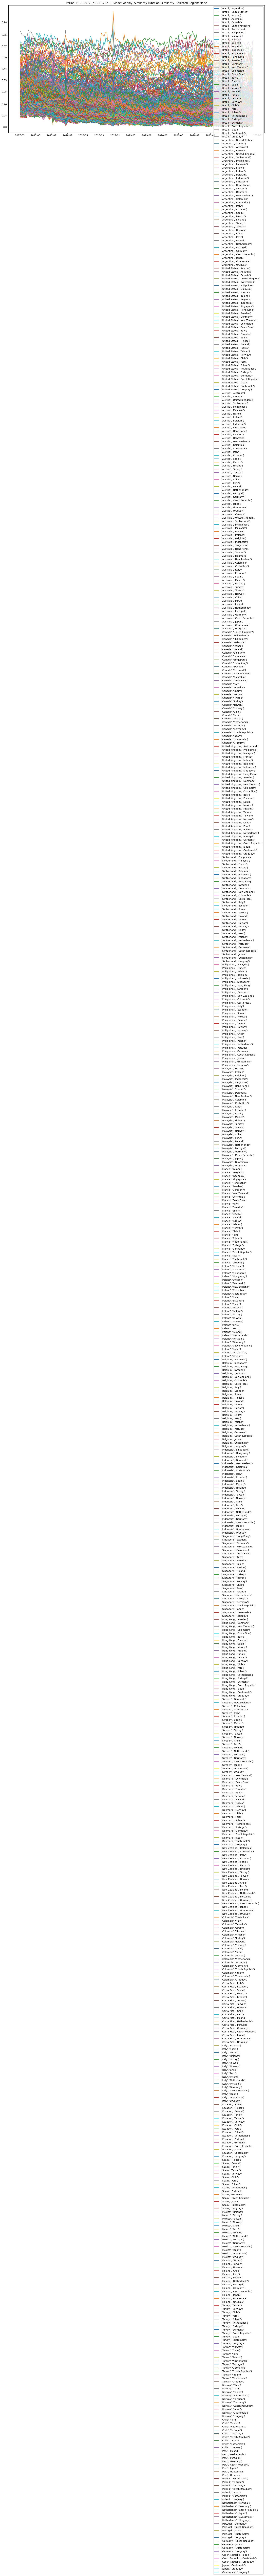

In [21]:
# get the region influence ranking
region_influence_dict = get_region_influence_ranking(region_dict, region_array)
print(region_influence_dict)

# add all outputs to an object and save it with a meaningful name
output = {"region_matrix_dict": region_dict, "region_array": region_array, "dates": dates, "info_dict": info_dict, "region_influence_dict": region_influence_dict}
np.save(os.path.join(OUTPUT_PATH, "region_influence_dict.npy"), output)

plot_region_matrix_dict(region_dict, dates, info_dict)

In [22]:
# print the playlists for the regions in mixedDF for a specific date
def print_playlists(mixedDF : pd.DataFrame, date : datetime.date):
    # get the regional weekly charts for the date range
    regional_charts = [get_regional_weekly_charts_ranking(get_charts_by_region(mixedDF, region), date) for region in mixedDF["region"].unique()]
    # print the playlists
    for i, region in enumerate(mixedDF["region"].unique()):
        print(region)
        print("Length of the playlist: {}".format(len(regional_charts[i])))
        print(regional_charts[i][["title", "artist"]].head(200))
        print()

# find the intersection of the playlists for the regions in mixedDF for a specific date with its ranking at each region as a new column
def print_intersection_playlists(mixedDF : pd.DataFrame, date : datetime.date):
    # get the regional weekly charts for the date range
    regional_charts = [get_regional_weekly_charts_ranking(get_charts_by_region(mixedDF, region), date) for region in mixedDF["region"].unique()]
    # find the intersection of the playlists
    intersection = set(regional_charts[0]["track_id"]).intersection(*[set(regional_charts[i]["track_id"]) for i in range(1, len(regional_charts))])
    # print the playlists
    for i, region in enumerate(mixedDF["region"].unique()):
        print(region)
        print(regional_charts[i][regional_charts[i]["track_id"].isin(intersection)][["title", "artist", "rank"]].head(200))
        print()
        # also print the similarty between the regional playlists according to the weighted similarity
        for j, region2 in enumerate(mixedDF["region"].unique()):
            if i == j:
                continue
            print("Similarity between {} and {}: {}".format(region, region2, get_similarity_weighted(0.5, 0.5)(regional_charts[i], regional_charts[j])))


#print_playlists(mixedDF, (datetime.datetime(2021,11,23).date(), datetime.datetime(2021,11,30).date()))
#print_intersection_playlists(mixedDF, (datetime.datetime(2021,11,23).date(), datetime.datetime(2021,11,30).date()))

Argentina
Length of the playlist: 252
                  title                      artist
0                   Bar               TINI, L-Gante
8       Salimo de Noche           Tiago PZK, Trueno
16           DANCE CRIP                      Trueno
24       Una Vaina Loca  Fuego, Manuel Turizo, Duki
32          Antes de Ti   Rusherking, Maria Becerra
...                 ...                         ...
1472  Cuando Me Enamoro                   Banda XXI
1476         2:50 Remix             MYA, TINI, Duki
1477             Bésame               El Reja, Lira
1481    La Noche Sin Tí                  Los Huayra
1485         EL MAKINON     KAROL G, Mariah Angeliq

[200 rows x 2 columns]

Australia
Length of the playlist: 246
                          title                artist
0                    Easy On Me                 Adele
8     STAY (with Justin Bieber)         The Kid LAROI
16      Cold Heart - PNAU Remix  Elton John, Dua Lipa
24                   Heat Waves         Glass Animals
32   